In [2]:
# FIRST ALL IMPORTS
import pandas as pd
from ipywidgets import *
import copy
import matplotlib.pyplot as plt
import tsam.timeseriesaggregation as tsam
from IPython.core.display import display
from IPython.display import Image

from IPython.display import clear_output

import base64
from io import StringIO
import os
%matplotlib inline

### <font color='#023d6b'>1. Upload  your data</font>
It needs to be of .csv format, while the first column is the time index. If you just want to use the example data, directly click "Show data".

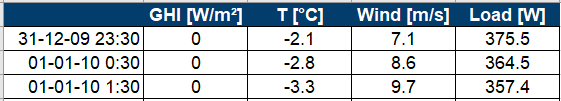

In [3]:
PATH = os.getcwd()
#Image(filename = os.path.join(PATH, "data_structure.png"))

In [4]:
raw_data=None

In [5]:
uploader = widgets.FileUpload(
                description="Select data",
                accept='.csv',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
                multiple=False,  # True to accept multiple files upload else False
            )
uploader.add_class("right-space-class")

button_data = Button(description="Show data", icon='check')

# define what happens in cas that the button is clicked
HBox(children=[uploader, button_data])

In [6]:
# the data output function is defined further below
data_output = Output()
data_output

Output()

### <font color='#023d6b'>2. Define aggregation method and parameters</font>

In [57]:
steps = widgets.BoundedIntText(
            value=24,
            description='Time steps per period:',
            disabled=False,
            style={'description_width': 'initial'},
            min=1,
            max=168,
            layout=Layout(width='17.5%')
        )

segments = widgets.BoundedIntText(
            value=24,
            min=1,
            max=168,
            step=1,
            description='Segments per period:',
            disabled=False,
            style={'description_width': 'initial'},
            layout=Layout(width='17%')
        )

periods = widgets.BoundedIntText(
            value=10,
            min=1,
            max=100,
            step=1,
            description='Periods to aggregate:',
            disabled=False,
            style={'description_width': 'initial'},
            layout=Layout(width='17%')
        )

algorithm = widgets.Dropdown(
                options=[alg for alg in tsam.TimeSeriesAggregation.CLUSTER_METHODS],
                value='hierarchical',
                description='Algorithm:',
                disabled=False,
                style={'description_width': 'initial'},
                layout=Layout(width='17%')
            )

button_agr = Button(description="Aggregate", button_style="success", icon='check' , layout=Layout(width='20%'))

params = HBox([steps, segments, periods, algorithm, button_agr])
params.layout.justify_content="space-around"

display(params)

### <font color='#023d6b'>3. Show and download your results</font>

In [58]:
plot1 = Output()
plot1

Output()

In [59]:
### THE FUNCTIONALITY

In [60]:
show_original = True

@data_output.capture(clear_output=True)
def onclick_data(button):
    if not uploader.data:
        display(HTML("Sample data chosen."))
        raw_data = pd.read_csv("testdata.csv", index_col = 0)
    else:
        raw_data = pd.read_csv(StringIO(str(uploader.data[0],'utf-8')), index_col = 0)
               
    row, col = raw_data.shape
    
    periods.max = int(row/steps.value)
    
    display(HTML("Number of time series: " + str(col)))
    display(HTML("Number of time steps: " + str(row)))
    
    global show_original
    show_original = True
    
    onclick_agr(button_data)
    
    return raw_data
            
raw_data = button_data.on_click(onclick_data)

In [61]:
def plot_aggregation(predictedPeriods, raw_data, attribute):
    global show_original
    
    if show_original == True:
        fig= plt.figure()
        fig, axes = plt.subplots(figsize = [8, 1.6], dpi = 100, nrows = 1, ncols = 1 )
        stacked_raw, timeindex = tsam.unstackToPeriods(copy.deepcopy(raw_data[attribute]), steps.value)

        cax = axes.imshow(stacked_raw.values.T, interpolation = 'nearest', vmin = raw_data[attribute].min(), vmax = raw_data[attribute].max())

        axes.set_aspect('auto')  
        axes.set_ylabel('Steps')
        axes.set_xlabel('Periods')
    else:
        fig= plt.figure()
        fig, axes = plt.subplots(figsize = [8, 1.6], dpi = 100, nrows = 1, ncols = 2, gridspec_kw = {'width_ratios':[1, 1.1],} )
        stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(predictedPeriods[attribute]), steps.value)
        stacked_raw, timeindex = tsam.unstackToPeriods(copy.deepcopy(raw_data[attribute]), steps.value)

        cax = axes.flat[1].imshow(stacked.values.T, interpolation = 'nearest', vmin = raw_data[attribute].min(), vmax = raw_data[attribute].max())
        cax = axes.flat[0].imshow(stacked_raw.values.T, interpolation = 'nearest', vmin = raw_data[attribute].min(), vmax = raw_data[attribute].max())
        fig.subplots_adjust(right = 1.7, wspace = 0.5)

        axes.flat[0].set_aspect('auto')  
        axes.flat[1].set_aspect('auto')  
        axes.flat[0].set_ylabel('Steps')
        axes.flat[0].set_xlabel('Periods')
        axes.flat[1].set_xlabel('Periods')
    
    cbar=plt.colorbar(cax, ax=axes)

    cbar.set_label(attribute)    
    return fig

In [62]:
def get_html(df, title):
    filename = "data_ts_"+str(steps.value)+"_seg_"+str(segments.value)+"_per_"+str(periods.value)+"_alg_"+algorithm.value+".csv"
    
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a class="btn btn-success s6" download="{filename}" href="data:text/csv;base64,{payload}" target="_blank" style="background-color:#b9d25f; text-transform:capitalize; color: black;">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    
    return html

def create_download_link(df1, title):
    html1 = get_html(df1, title)
    return html1

In [85]:
@plot1.capture(clear_output=True)
def onclick_agr(button):
    global show_original
    if button.description == 'Aggregate':
        show_original = False

    if not uploader.data:
        display(HTML("Sample data chosen."))
        raw_data = pd.read_csv("testdata.csv", index_col = 0)
    else:
        raw_data = pd.read_csv(StringIO(str(uploader.data[0],'utf-8')), index_col = 0)
    with plot1:
        aggregation = tsam.TimeSeriesAggregation(raw_data, noTypicalPeriods = periods.value,
                                                 hoursPerPeriod = steps.value, clusterMethod = algorithm.value,
                                                 solver='glpk', segmentation=True, noSegments=segments.value)
        typPeriods = aggregation.createTypicalPeriods()
        predictedPeriods = aggregation.predictOriginalData()
        periodsOrder = pd.DataFrame(aggregation.clusterOrder, columns=['Periods Order'])
        accuracyIndicators = aggregation.accuracyIndicators()

        if show_original == False:
            data_reduction = widgets.FloatText(
                                value=round((1-periods.value * segments.value/aggregation.timeSeries.shape[0])*100,2),
                                description='Data reduction (%): ',
                                disabled=True,
                                style={'description_width': 'initial'},
                            )

            error = widgets.FloatText(
                                value=accuracyIndicators['RMSE'].mean(),
                                description='Root mean squared error: ',
                                disabled=True,
                                style={'description_width': 'initial'},
                            )
            display(HBox(children=[data_reduction, error]))


            label_original = widgets.HTML(value="<h6 style='color:#023d6b'><b>Original Data</b></h6>")
            label_aggregated = widgets.HTML(value="<h6 style='color:#023d6b'><b>Aggregated Data</b></h6>")
            display(HBox(children=[label_original, label_aggregated], layout=Layout(justify_content="space-around")))
        else:
            label_original = widgets.HTML(value="<h6 style='color:#023d6b'><b>Original Data</b></h6>")
            display(HBox(children=[label_original], layout=Layout(left='25%')))

        for attr in raw_data.columns:
            figgg = plot_aggregation(predictedPeriods, raw_data, attr)
            display(figgg)
            del figgg

        if show_original == False:
            html1 = create_download_link(typPeriods, 'Download Aggregated Time Series')
            display(HBox(children=[HTML(html1)], layout=Layout(justify_content="center")))

            display(HTML('<hr><h6><b>Further Results</b></h6>'))

            p2 = '<p><b>The Predicted Time Series</b> are a representation of the aggregated time series that are unfold to \
                  the original size of the time series in order to visualize the impact of the aggregation on the time \
                  series, e.g. regarding variance underestimation due to aggregation.</p>'
            html2 = create_download_link(predictedPeriods, 'Download Predicted Time Series')
            v2 = VBox(children=[HTML(p2), HTML(html2)])

            div = '<div style="border-left: 6px solid #023d6b; margin-right: 20px; margin-left: 10px;"></div>'

            html3 = create_download_link(periodsOrder, 'Download Periods Order')
            p3 = '<p><b>The Periods Order</b> is a sequence of integers indicating which period of the original time series is \
            assigned to which typical period. For example, if one year is clustered to 20 typical days, the periods order \
            consists of 365 integers between 0 and 19 showing that e.g. the first day of the year is assigned to typical day \
            number 3, the second one to typical day number 1, the third one to typical day number 3 and so on. The periods \
            order is important for modeling seasonal storage as shown by Kotzur et al. \
            <a href="https://www.sciencedirect.com/science/article/pii/S0306261918300242" title="">link</a>.</p>'
            v3 = VBox(children=[HTML(p3), HTML(html3)])

            display(HBox(children=[v2, HTML(div), v3], layout=Layout(justify_content="space-around")))

        show_original = False
                
button_agr.on_click(onclick_agr)

In [83]:
# button_agr.click()

In [ ]:
# onclick_agr(button_agr)

Authors: Maximilian Hoffman, Leander Kotzur, Detlef Stolten